## Kaggle Resnet50
- credit: https://www.kaggle.com/jtmurkz/keras-resnet50-0-96lb

In [3]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob 
import matplotlib.pyplot as plt
import csv

import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

from keras_preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from IPython.display import clear_output

## Processing the data
Now it's time to import the data. What I want to do is:

1. Load and display some positive and negative test examples
2. Split the train data into train and dev sets

In [4]:
path = "input/subset_data/" 
labels = pd.read_csv(path + 'train_labels_full.csv')
train_path = path + 'train/'
test_path = path + 'test_with_outputs/'

## Create a dataframe which contains every training examples path, id and label:

In [5]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
df['id'] = df.path.map(lambda x: ((x.split("n")[2].split('.')[0])[1:]))
df = df.merge(labels, on = "id")
df.head(3)

,path,id,label
0,input/subset_data/train/cc3f88c975016c14a6d88c...,cc3f88c975016c14a6d88cdd1c575050a4c22101,1
1,input/subset_data/train/2c883bf56b24dfc8a4e45d...,2c883bf56b24dfc8a4e45d318bf106a5ce642afb,0
2,input/subset_data/train/d817ec52de2d5930362bd9...,d817ec52de2d5930362bd994b3dcd5fb73081877,1


## Choose 4 random positve and negative examples, find their respective path then display them in a subplot:

In [6]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

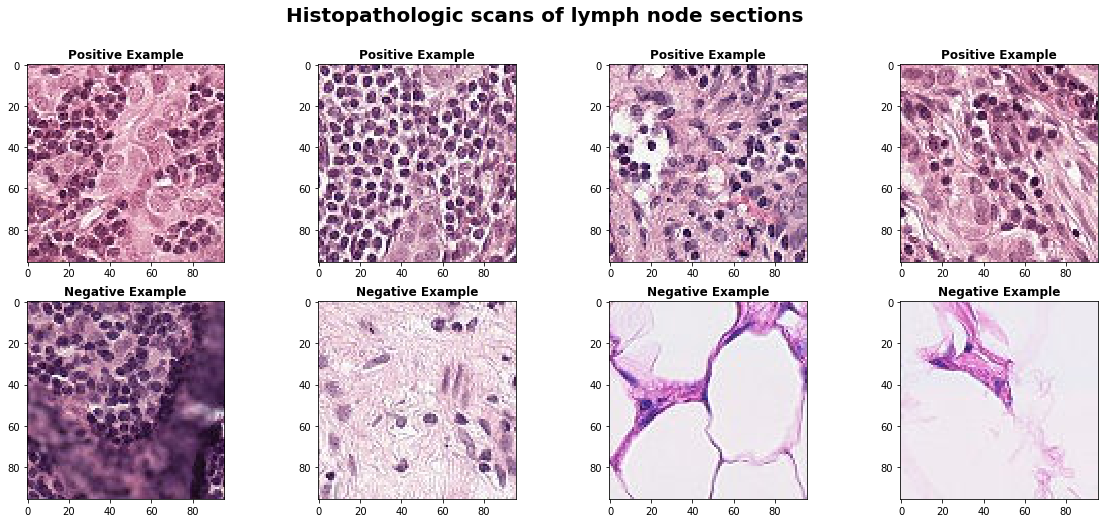

In [7]:
positive_indices = list(np.where(df["label"] == True)[0])
negative_indices = list(np.where(df["label"] == False)[0])
rand_pos_inds = random.sample(positive_indices, 4)
rand_neg_inds = random.sample(negative_indices, 4)

fig, ax = plt.subplots(2,4, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20, fontweight='bold')

for i in range(0, 4):
    ax[0,i].imshow(readImage(df.iloc[rand_pos_inds[i],0]))
    ax[0,i].set_title("Positive Example", fontweight='bold')
    
    ax[1,i].imshow(readImage(df.iloc[rand_neg_inds[i],0]))
    ax[1,i].set_title("Negative Example", fontweight='bold')

## Train/Validation Split and Loading the Data
Increasing the size of the image results in a much higher performance.

In [8]:
IMG_SIZE = 196
BATCH_SIZE = 128

In [9]:
test_list = os.listdir(test_path)
train_list = os.listdir(train_path)
print("There are " + str(len(train_list)) + " training examples.")
print("There are " + str(len(test_list)) + " test examples.")

There are 4000 training examples.
There are 1000 test examples.


In [10]:
df['label'] = df['label'].astype(str)
train, valid = train_test_split(df, test_size=0.2, stratify = df['label'])

## Going to split 20% of the training set into a validation set.

In [11]:
df['label'] = df['label'].astype(str)
train, valid = train_test_split(df, test_size=0.2, stratify = df['label'])

In [12]:
"This is not effective!"
def crop_centre(image, crop_length):
    original_size = image.shape[0]
    centre = original_size // 2
    lower_bound = centre - crop_length // 2 
    upper_bound = centre + crop_length // 2
    image = image[(lower_bound):(upper_bound),(lower_bound):(upper_bound)]
    return image

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  vertical_flip = True,
                                  horizontal_flip = True,
                                  rotation_range=90,
                                  zoom_range=0.2, 
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.05,
                                  channel_shift_range=0.1)

test_datagen = ImageDataGenerator(rescale = 1./255) 

In [14]:
train_generator = train_datagen.flow_from_dataframe(dataframe = train, 
                                                    directory = None,
                                                    x_col = 'path', 
                                                    y_col = 'label',
                                                    target_size = (IMG_SIZE,IMG_SIZE),
                                                    class_mode = "binary",
                                                    batch_size=BATCH_SIZE,
                                                    seed = 110318,
                                                    shuffle = True)

Found 3200 images belonging to 2 classes.


In [15]:
valid_generator = test_datagen.flow_from_dataframe(dataframe = valid,
                                                   directory = None,
                                                   x_col = 'path',
                                                   y_col = 'label',
                                                   target_size = (IMG_SIZE,IMG_SIZE),
                                                   class_mode = 'binary',
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = False)

Found 800 images belonging to 2 classes.


In [16]:
from keras.applications.resnet50 import ResNet50

dropout_fc = 0.5

conv_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (IMG_SIZE,IMG_SIZE,3))

my_model = Sequential()

my_model.add(conv_base)
my_model.add(Flatten())
my_model.add(Dense(256, use_bias=False))
my_model.add(BatchNormalization())
my_model.add(Activation("relu"))
my_model.add(Dropout(dropout_fc))
my_model.add(Dense(1, activation = "sigmoid"))

Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690112  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_50 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total para

## Note:
As we're using ResNet50 trained on ImageNet, we're going to need to train the last few layers instead of the just the last one. Cell images are quite different to what you see on ImageNet.

In [18]:
conv_base.Trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name == 'res5a_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [19]:
from keras import optimizers
my_model.compile(optimizers.Adam(0.001), loss = "binary_crossentropy", metrics = ["accuracy"])

In [20]:
train_step_size = train_generator.n // train_generator.batch_size
valid_step_size = valid_generator.n // valid_generator.batch_size

In [21]:
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=2, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [22]:
history = my_model.fit_generator(train_generator,
                                     steps_per_epoch = train_step_size,
                                     epochs = 50,
                                     validation_data = valid_generator,
                                     validation_steps = valid_step_size,
                                     callbacks = [reduce, earlystopper],
                                     verbose = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
25/25 [==============================] - 49s 2s/step - loss: 0.5036 - acc: 0.8178 - val_loss: 1.6361 - val_acc: 0.7826
Epoch 2/50
25/25 [==============================] - 35s 1s/step - loss: 0.3193 - acc: 0.8681 - val_loss: 0.3857 - val_acc: 0.8973
Epoch 3/50
25/25 [==============================] - 34s 1s/step - loss: 0.2862 - acc: 0.8825 - val_loss: 0.3650 - val_acc: 0.8958
Epoch 4/50
25/25 [==============================] - 34s 1s/step - loss: 0.2726 - acc: 0.8919 - val_loss: 0.2917 - val_acc: 0.8914
Epoch 5/50
25/25 [==============================] - 34s 1s/step - loss: 0.2550 - acc: 0.8987 - val_loss: 0.5227 - val_acc: 0.8289

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/50
25/25 [==============================] - 34s 1s/step - loss: 0.2256 - acc: 0.9097 - val_loss: 0.3634 - val_acc: 0.8557

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 7/

## Analysis
Now that our model has been trained, it is time to plot some training graphs to see how our accuracies and losses varied over epochs.

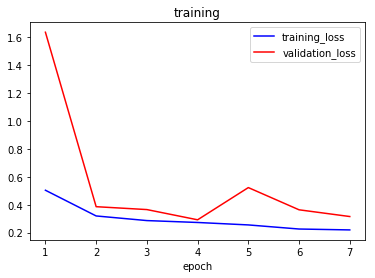

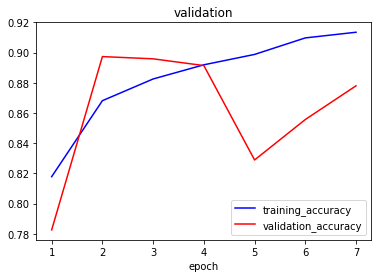

In [23]:
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.savefig("training.png", bbox_inches='tight')
plt.show()

plt.plot(epochs, history.history['acc'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_acc'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')
plt.savefig("validation.png", bbox_inches='tight')
plt.show()

Found 800 images belonging to 2 classes.


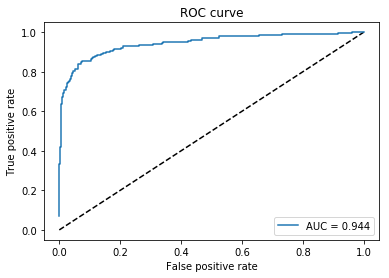

In [24]:
roc_validation_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(valid,
                                                                                  x_col = 'path',
                                                                                  y_col = 'label',
                                                                                  target_size = (IMG_SIZE,IMG_SIZE),
                                                                                  class_mode = 'binary',
                                                                                  batch_size = BATCH_SIZE,
                                                                                  shuffle = False)
predictions = my_model.predict_generator(roc_validation_generator, steps=len(roc_validation_generator), verbose=2)
false_positive_rate, true_positive_rate, threshold = roc_curve(roc_validation_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('ROC_PLOT.png', bbox_inches='tight')
plt.show()

## Predictions
For predictions we are going to use Test Time Augmentation. For each test image we will augment it 5 ways and average the prediction. We've also used ensemble learning by averaging the results of 3 versions of this model, it improves result.

In [25]:
testdf = pd.DataFrame({'path': glob(os.path.join(test_path, '*.tif'))})
testdf['id'] = testdf.path.map(lambda x: (x.split("/")[3].split('.')[0]))
testdf.head(3)

,path,id
0,input/subset_data/test_with_outputs/06ee549b7c...,06ee549b7c9cb3e81d3e26d5eb09d5a72701d6d2
1,input/subset_data/test_with_outputs/333aa08b55...,333aa08b55948996065dd425b5d27e6dbd56b411
2,input/subset_data/test_with_outputs/28f74e4f69...,28f74e4f690f2538ba85a6489adbae5eadad622b


In [26]:
tta_datagen = ImageDataGenerator(rescale=1./255, #Normalise
                                 vertical_flip = True,
                                 horizontal_flip = True,
                                 rotation_range=90,
                                 zoom_range=0.2, 
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.05,
                                 channel_shift_range=0.1)

In [27]:
tta_steps = 5
predictions_dataframe = pd.DataFrame()
for index in range(0, len(testdf)):
    data_frame = pd.DataFrame({'path': testdf.iloc[index,0]}, index=[index])
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[3].split('.')[0])
    img_path = data_frame.iloc[0,0]
    test_img = cv2.imread(img_path)
    test_img = cv2.resize(test_img,(IMG_SIZE,IMG_SIZE))
    test_img = np.expand_dims(test_img, axis = 0)  
    predictionsTTA = []
    for i in range(0, tta_steps):
        preds = my_model.predict_generator(tta_datagen.flow_from_dataframe(dataframe = data_frame,
                                                                           directory = None,
                                                                           x_col = 'path',
                                                                           target_size = (IMG_SIZE, IMG_SIZE),
                                                                           class_mode = None,
                                                                           batch_size = 1,
                                                                           shuffle = False), steps = 1)
        predictionsTTA.append(preds)
    clear_output()
    prediction_entry = np.array(np.mean(predictionsTTA, axis=0))
    data_frame['label'] = prediction_entry
    predictions_dataframe = pd.concat([submission, data_frame[['id', 'label']]])

NameError: name 'submission' is not defined

In [ ]:
predictions_dataframe.set_index('id')
predictions_dataframe.head(10)
#print("shape: ",predictions_dataframe.shape)

In [ ]:
''' A classical mathematical rounding by Voznica '''
def round_half_up(x,y=0): 
    m = int('1'+'0'*y) # multiplier - how many positions to the right
    q = x*m # shift to the right by multiplier
    c = int(q) # new number
    i = int( (q-c)*10 ) # indicator number on the right
    if i >= 5:
        c += 1
    return c/m
''' Just ignore above '''

'''A simple manual way to check prediction accuracy on test data set'''
predictions = dict()
truth = dict()

# add id: label to predictions
for index, row in predictions_dataframe.iterrows():
    image_id = row['id']
    image_label = row['label']
    predictions[image_id] = round_half_up(image_label)
    
# add id: label to truth 
with open('input/subset_data/train_labels_full.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    next(readCSV, None)
    for row in readCSV:
        image_id_csv = row[0]
        image_label_csv = row[1]
        if image_id_csv in predictions.keys():
            truth[image_id_csv] = image_label_csv

In [ ]:
number_of_correct_predictions = 0

for image_id in predictions.keys():
    if int(predictions[image_id]) == int(truth[image_id]):
        number_of_correct_predictions += 1

accuracy = number_of_correct_predictions/len(predictions)       
print("accuracy on test data set: ", accuracy)

In [ ]:
my_model.save("savedmodel.h5")

# Visualizations

In [1]:
import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras import backend as K

def normalize(x):
    """utility function to normalize a tensor.
    # Arguments
        x: An input tensor.
    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.
    # Arguments
        x: A numpy-array representing the generated image.
    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.
    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.
    # Returns
        A processed numpy-array representing the generated image.
    """
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()


def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=30,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_range=(0, None)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.
    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.
        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.
        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])

                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    print("Skipped filter as loss stuck to 0")
                    return None

            # Calulate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = [process_image(img, input_img_data[0])]

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.
        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for
        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters
        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                    width_margin: width_margin + output_dim[0],
                    height_margin: height_margin + output_dim[1], :] = img

        # save the result to disk
        save_img('resnet_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)

    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else len(output_layer.get_weights()[1]))
    assert(filter_lower >= 0
           and filter_upper <= len(output_layer.get_weights()[1])
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    # iterate through each filter and generate its corresponding image
    processed_filters = []
    for f in range(filter_lower, filter_upper):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)

Using TensorFlow backend.


In [2]:

for layer in my_model.layers[0].layers:
    if isinstance(layer, layers.Conv2D):
        print(layer.name)

NameError: name 'my_model' is not defined

In [ ]:
for layer in reversed(my_model.layers[0].layers):
    if isinstance(layer, layers.Conv2D):
        visualize_layer(my_model.layers[0], layer.name)

In [ ]:
from __future__ import print_function

from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
import scipy
import argparse

from keras.applications import inception_v3
from keras import backend as K


base_image_path = "input/subset_data/test_with_outputs/0bee7fbb279baaadf3dce8eef641c2269d12030b.tif"
result_prefix = "deepdream"

# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
settings = {
    'features': {
        'conv1': 0.2,
        'res3b_branch2b':0.1,
        'res5b_branch2a':0.1

    },
}


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

K.set_learning_phase(0)
inner_model = my_model.layers[0]
dream = inner_model.get_input_at(0)
print('inner_model loaded.')

# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in inner_model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    if layer_name not in layer_dict:
        raise ValueError('Layer ' + layer_name + ' not found in inner_model.')
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values


def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x


"""Process:
- Load the original image.
- Define a number of processing scales (i.e. image shapes),
    from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.
To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.
"""


# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.02  # Gradient ascent step size
num_octave = 8  # Number of scales at which to run gradient ascent
octave_scale = 1.1  # Size ratio between scales
iterations = 10  # Number of ascent steps per scale
max_loss = 10.

img = preprocess_image(base_image_path)
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img*0.9

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

save_img(result_prefix + '.png', deprocess_image(np.copy(img)))

In [ ]:
from math import floor, sqrt, ceil
def display_activation(activations, act_index):
    activation = activations[act_index]
    print(activation.shape)
    num_layers = 16
    
    row_size = floor(sqrt(num_layers))
    col_size = ceil(num_layers/row_size)

    index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*5,col_size*2))
    for row in range(0,row_size):
        for col in range(0,col_size):
            if index >= num_layers:
                break
            ax[row][col].imshow(activation[0, :, :, index], cmap='gray')
            index += 1
    plt.savefig("resnet_activations_index_%d.png"%(act_index))

In [ ]:

from keras.models import Model
layer_outputs = [layer.output for layer in inner_model.layers[1:]]
activation_model = Model(inputs=inner_model.get_input_at(0), outputs=layer_outputs)
X_train, Y_train = next(train_generator)
activations = activation_model.predict(X_train[10].reshape(1, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for i, layer in enumerate(inner_model.layers[1:]):
    if isinstance(layer, Activation):
        print(i)
        print(layer.name)
    
#Layer at index 3,7 are the activation layers

In [ ]:
display_activation(activations, 3)


In [ ]:
display_activation(activations, 43)

In [ ]:
display_activation(activations,101)

In [ ]:
display_activation(activations, 173)

In [28]:
def iter_occlusion(image, size=8):

    occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
    occlusion_center = np.full((size, size, 1), [0.5], np.float32)
    occlusion_padding = size * 2

    # print('padding...')
    image_padded = np.pad(image, ( \
                        (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
                        ), 'constant', constant_values = 0.0)

    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()

            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
                x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
                = occlusion

            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

            yield x - occlusion_padding, y - occlusion_padding, \
                  tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]


In [29]:
X_train, Y_train = next(valid_generator)

In [30]:
for idx, want in enumerate(Y_train == 1):
    if want:
        print(idx)

0
2
3
4
13
14
17
19
20
22
24
26
27
29
33
43
46
47
51
52
53
55
57
60
61
62
63
64
66
70
75
77
78
83
84
86
89
91
92
96
106
107
109
114
117
119
125
126


0.0
0


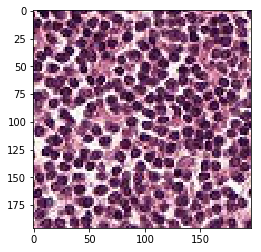

In [31]:
i = 11
# for example
data = X_train[i]
print(Y_train[i])
correct_class = np.argmax(Y_train[i])
print(correct_class)

# input tensor for model.predict
inp = data.reshape(1, IMG_SIZE, IMG_SIZE, 3)

# image data for matplotlib's imshow
img = data.reshape(IMG_SIZE, IMG_SIZE, 3)

# occlusion
img_size = img.shape[0]
occlusion_size = 4

# preview
_ = plt.imshow(img)
plt.savefig("preocclusion-%d-%d.png"%(i,Y_train[i]))


In [32]:
print('occluding...')

heatmap = np.zeros((IMG_SIZE, IMG_SIZE), np.float32)
class_pixels = np.zeros((IMG_SIZE, IMG_SIZE), np.int16)

from collections import defaultdict
counters = defaultdict(int)

for n, (x, y, img_float) in enumerate(iter_occlusion(data, size=occlusion_size)):   

    X = img_float.reshape(1, IMG_SIZE, IMG_SIZE, 3)
    out = my_model.predict(X)
    print('#{}: {} @ {} (correct class: {})'.format(n, np.argmax(out), np.amax(out), out[0][correct_class]))
    #print('x {} - {} | y {} - {}'.format(x, x + occlusion_size, y, y + occlusion_size))

    heatmap[y:y + occlusion_size, x:x + occlusion_size] = out[0][correct_class]
    class_pixels[y:y + occlusion_size, x:x + occlusion_size] = np.argmax(out)
    counters[np.argmax(out)] += 1

pred = my_model.predict(inp)
print('Correct class: {}'.format(correct_class))
print('Predicted class: {} (prob: {})'.format(np.argmax(pred), np.amax(out)))

print('Predictions:')
for class_id, count in counters.items():
    print('{}: {}'.format(class_id, count))

occluding...
#0: 0 @ 0.0071106236428022385 (correct class: 0.0071106236428022385)
#1: 0 @ 0.007068987935781479 (correct class: 0.007068987935781479)
#2: 0 @ 0.00724066374823451 (correct class: 0.00724066374823451)
#3: 0 @ 0.0065099638886749744 (correct class: 0.0065099638886749744)
#4: 0 @ 0.006933258380740881 (correct class: 0.006933258380740881)
#5: 0 @ 0.006944061256945133 (correct class: 0.006944061256945133)
#6: 0 @ 0.007105381228029728 (correct class: 0.007105381228029728)
#7: 0 @ 0.006835789419710636 (correct class: 0.006835789419710636)
#8: 0 @ 0.006619652267545462 (correct class: 0.006619652267545462)
#9: 0 @ 0.006936558987945318 (correct class: 0.006936558987945318)
#10: 0 @ 0.007449979893863201 (correct class: 0.007449979893863201)
#11: 0 @ 0.007446455303579569 (correct class: 0.007446455303579569)
#12: 0 @ 0.007513158954679966 (correct class: 0.007513158954679966)
#13: 0 @ 0.007241678424179554 (correct class: 0.007241678424179554)
#14: 0 @ 0.007410993333905935 (correct clas

#124: 0 @ 0.0075502172112464905 (correct class: 0.0075502172112464905)
#125: 0 @ 0.007796300575137138 (correct class: 0.007796300575137138)
#126: 0 @ 0.008251435123383999 (correct class: 0.008251435123383999)
#127: 0 @ 0.007813863456249237 (correct class: 0.007813863456249237)
#128: 0 @ 0.008141284808516502 (correct class: 0.008141284808516502)
#129: 0 @ 0.007348768413066864 (correct class: 0.007348768413066864)
#130: 0 @ 0.0074804252944886684 (correct class: 0.0074804252944886684)
#131: 0 @ 0.008316085673868656 (correct class: 0.008316085673868656)
#132: 0 @ 0.007366906385868788 (correct class: 0.007366906385868788)
#133: 0 @ 0.007588943466544151 (correct class: 0.007588943466544151)
#134: 0 @ 0.006958917248994112 (correct class: 0.006958917248994112)
#135: 0 @ 0.0065429056994616985 (correct class: 0.0065429056994616985)
#136: 0 @ 0.006619558669626713 (correct class: 0.006619558669626713)
#137: 0 @ 0.006607463583350182 (correct class: 0.006607463583350182)
#138: 0 @ 0.0067146262153983

#245: 0 @ 0.0076129380613565445 (correct class: 0.0076129380613565445)
#246: 0 @ 0.007695923559367657 (correct class: 0.007695923559367657)
#247: 0 @ 0.00767449801787734 (correct class: 0.00767449801787734)
#248: 0 @ 0.007208467461168766 (correct class: 0.007208467461168766)
#249: 0 @ 0.007247583474963903 (correct class: 0.007247583474963903)
#250: 0 @ 0.007461769971996546 (correct class: 0.007461769971996546)
#251: 0 @ 0.007452734280377626 (correct class: 0.007452734280377626)
#252: 0 @ 0.007303424179553986 (correct class: 0.007303424179553986)
#253: 0 @ 0.006802871357649565 (correct class: 0.006802871357649565)
#254: 0 @ 0.0071356943808496 (correct class: 0.0071356943808496)
#255: 0 @ 0.007182728964835405 (correct class: 0.007182728964835405)
#256: 0 @ 0.007098380941897631 (correct class: 0.007098380941897631)
#257: 0 @ 0.00741888303309679 (correct class: 0.00741888303309679)
#258: 0 @ 0.006840764544904232 (correct class: 0.006840764544904232)
#259: 0 @ 0.0070642330683767796 (correct

#365: 0 @ 0.008213460445404053 (correct class: 0.008213460445404053)
#366: 0 @ 0.007718580774962902 (correct class: 0.007718580774962902)
#367: 0 @ 0.007681041024625301 (correct class: 0.007681041024625301)
#368: 0 @ 0.0069742039777338505 (correct class: 0.0069742039777338505)
#369: 0 @ 0.0066792904399335384 (correct class: 0.0066792904399335384)
#370: 0 @ 0.007778648287057877 (correct class: 0.007778648287057877)
#371: 0 @ 0.007631278596818447 (correct class: 0.007631278596818447)
#372: 0 @ 0.007851211354136467 (correct class: 0.007851211354136467)
#373: 0 @ 0.00826316885650158 (correct class: 0.00826316885650158)
#374: 0 @ 0.007744729984551668 (correct class: 0.007744729984551668)
#375: 0 @ 0.007108601275831461 (correct class: 0.007108601275831461)
#376: 0 @ 0.007016415242105722 (correct class: 0.007016415242105722)
#377: 0 @ 0.007734788116067648 (correct class: 0.007734788116067648)
#378: 0 @ 0.00792020745575428 (correct class: 0.00792020745575428)
#379: 0 @ 0.007754021789878607 (co

#485: 0 @ 0.008355624042451382 (correct class: 0.008355624042451382)
#486: 0 @ 0.008552736602723598 (correct class: 0.008552736602723598)
#487: 0 @ 0.007668225560337305 (correct class: 0.007668225560337305)
#488: 0 @ 0.0074388920329511166 (correct class: 0.0074388920329511166)
#489: 0 @ 0.007067434955388308 (correct class: 0.007067434955388308)
#490: 0 @ 0.00854947417974472 (correct class: 0.00854947417974472)
#491: 0 @ 0.00759087922051549 (correct class: 0.00759087922051549)
#492: 0 @ 0.00764947896823287 (correct class: 0.00764947896823287)
#493: 0 @ 0.0073127164505422115 (correct class: 0.0073127164505422115)
#494: 0 @ 0.00838334672152996 (correct class: 0.00838334672152996)
#495: 0 @ 0.007950974628329277 (correct class: 0.007950974628329277)
#496: 0 @ 0.007630062289535999 (correct class: 0.007630062289535999)
#497: 0 @ 0.006750156637281179 (correct class: 0.006750156637281179)
#498: 0 @ 0.007379193790256977 (correct class: 0.007379193790256977)
#499: 0 @ 0.007352069951593876 (correc

#605: 0 @ 0.007443036884069443 (correct class: 0.007443036884069443)
#606: 0 @ 0.008122880011796951 (correct class: 0.008122880011796951)
#607: 0 @ 0.007965241558849812 (correct class: 0.007965241558849812)
#608: 0 @ 0.012297496199607849 (correct class: 0.012297496199607849)
#609: 0 @ 0.00992546696215868 (correct class: 0.00992546696215868)
#610: 0 @ 0.008946440182626247 (correct class: 0.008946440182626247)
#611: 0 @ 0.008153668604791164 (correct class: 0.008153668604791164)
#612: 0 @ 0.007824295200407505 (correct class: 0.007824295200407505)
#613: 0 @ 0.007976874709129333 (correct class: 0.007976874709129333)
#614: 0 @ 0.008841950446367264 (correct class: 0.008841950446367264)
#615: 0 @ 0.009433139115571976 (correct class: 0.009433139115571976)
#616: 0 @ 0.009348791092634201 (correct class: 0.009348791092634201)
#617: 0 @ 0.00784727931022644 (correct class: 0.00784727931022644)
#618: 0 @ 0.008495503105223179 (correct class: 0.008495503105223179)
#619: 0 @ 0.008002706803381443 (correc

#729: 0 @ 0.00632100086659193 (correct class: 0.00632100086659193)
#730: 0 @ 0.006396277341991663 (correct class: 0.006396277341991663)
#731: 0 @ 0.006250804290175438 (correct class: 0.006250804290175438)
#732: 0 @ 0.0074937837198376656 (correct class: 0.0074937837198376656)
#733: 0 @ 0.0074852281250059605 (correct class: 0.0074852281250059605)
#734: 0 @ 0.006777402013540268 (correct class: 0.006777402013540268)
#735: 0 @ 0.008723951876163483 (correct class: 0.008723951876163483)
#736: 0 @ 0.008443099446594715 (correct class: 0.008443099446594715)
#737: 0 @ 0.008356837555766106 (correct class: 0.008356837555766106)
#738: 0 @ 0.007263603620231152 (correct class: 0.007263603620231152)
#739: 0 @ 0.013280353508889675 (correct class: 0.013280353508889675)
#740: 0 @ 0.010055353865027428 (correct class: 0.010055353865027428)
#741: 0 @ 0.00784048717468977 (correct class: 0.00784048717468977)
#742: 0 @ 0.007570685353130102 (correct class: 0.007570685353130102)
#743: 0 @ 0.007230234332382679 (co

#848: 0 @ 0.007290091831237078 (correct class: 0.007290091831237078)
#849: 0 @ 0.006896374747157097 (correct class: 0.006896374747157097)
#850: 0 @ 0.007176871877163649 (correct class: 0.007176871877163649)
#851: 0 @ 0.0070315576158463955 (correct class: 0.0070315576158463955)
#852: 0 @ 0.007127233315259218 (correct class: 0.007127233315259218)
#853: 0 @ 0.007280042860656977 (correct class: 0.007280042860656977)
#854: 0 @ 0.007736658211797476 (correct class: 0.007736658211797476)
#855: 0 @ 0.006953178904950619 (correct class: 0.006953178904950619)
#856: 0 @ 0.006841687951236963 (correct class: 0.006841687951236963)
#857: 0 @ 0.0070471493527293205 (correct class: 0.0070471493527293205)
#858: 0 @ 0.007175149396061897 (correct class: 0.007175149396061897)
#859: 0 @ 0.007132566999644041 (correct class: 0.007132566999644041)
#860: 0 @ 0.006604781839996576 (correct class: 0.006604781839996576)
#861: 0 @ 0.007446416188031435 (correct class: 0.007446416188031435)
#862: 0 @ 0.007846584543585777

#973: 0 @ 0.007068304810672998 (correct class: 0.007068304810672998)
#974: 0 @ 0.006477636750787497 (correct class: 0.006477636750787497)
#975: 0 @ 0.006904377602040768 (correct class: 0.006904377602040768)
#976: 0 @ 0.006463394965976477 (correct class: 0.006463394965976477)
#977: 0 @ 0.007141060661524534 (correct class: 0.007141060661524534)
#978: 0 @ 0.007066862657666206 (correct class: 0.007066862657666206)
#979: 0 @ 0.006790054030716419 (correct class: 0.006790054030716419)
#980: 0 @ 0.007167877163738012 (correct class: 0.007167877163738012)
#981: 0 @ 0.007663883734494448 (correct class: 0.007663883734494448)
#982: 0 @ 0.007830297574400902 (correct class: 0.007830297574400902)
#983: 0 @ 0.00843522697687149 (correct class: 0.00843522697687149)
#984: 0 @ 0.008688334375619888 (correct class: 0.008688334375619888)
#985: 0 @ 0.008341053500771523 (correct class: 0.008341053500771523)
#986: 0 @ 0.008904698304831982 (correct class: 0.008904698304831982)
#987: 0 @ 0.00830069649964571 (corre

#1093: 0 @ 0.008973920717835426 (correct class: 0.008973920717835426)
#1094: 0 @ 0.008457083255052567 (correct class: 0.008457083255052567)
#1095: 0 @ 0.007989143952727318 (correct class: 0.007989143952727318)
#1096: 0 @ 0.008379450999200344 (correct class: 0.008379450999200344)
#1097: 0 @ 0.007848612032830715 (correct class: 0.007848612032830715)
#1098: 0 @ 0.009235547855496407 (correct class: 0.009235547855496407)
#1099: 0 @ 0.009917143732309341 (correct class: 0.009917143732309341)
#1100: 0 @ 0.009560531936585903 (correct class: 0.009560531936585903)
#1101: 0 @ 0.009076005779206753 (correct class: 0.009076005779206753)
#1102: 0 @ 0.008315833285450935 (correct class: 0.008315833285450935)
#1103: 0 @ 0.008669983595609665 (correct class: 0.008669983595609665)
#1104: 0 @ 0.008244394324719906 (correct class: 0.008244394324719906)
#1105: 0 @ 0.0078011006116867065 (correct class: 0.0078011006116867065)
#1106: 0 @ 0.008194565773010254 (correct class: 0.008194565773010254)
#1107: 0 @ 0.00867

#1213: 0 @ 0.011060711927711964 (correct class: 0.011060711927711964)
#1214: 0 @ 0.011602949351072311 (correct class: 0.011602949351072311)
#1215: 0 @ 0.007761090528219938 (correct class: 0.007761090528219938)
#1216: 0 @ 0.018204962834715843 (correct class: 0.018204962834715843)
#1217: 0 @ 0.008082698099315166 (correct class: 0.008082698099315166)
#1218: 0 @ 0.007865375839173794 (correct class: 0.007865375839173794)
#1219: 0 @ 0.007180993910878897 (correct class: 0.007180993910878897)
#1220: 0 @ 0.007504168897867203 (correct class: 0.007504168897867203)
#1221: 0 @ 0.0068891774863004684 (correct class: 0.0068891774863004684)
#1222: 0 @ 0.00814426876604557 (correct class: 0.00814426876604557)
#1223: 0 @ 0.008022263646125793 (correct class: 0.008022263646125793)
#1224: 0 @ 0.007382261101156473 (correct class: 0.007382261101156473)
#1225: 0 @ 0.008964138105511665 (correct class: 0.008964138105511665)
#1226: 0 @ 0.008863011375069618 (correct class: 0.008863011375069618)
#1227: 0 @ 0.0091151

#1333: 0 @ 0.009855508804321289 (correct class: 0.009855508804321289)
#1334: 0 @ 0.008764407597482204 (correct class: 0.008764407597482204)
#1335: 0 @ 0.01199115440249443 (correct class: 0.01199115440249443)
#1336: 0 @ 0.012246575206518173 (correct class: 0.012246575206518173)
#1337: 0 @ 0.013908079825341702 (correct class: 0.013908079825341702)
#1338: 0 @ 0.008985950611531734 (correct class: 0.008985950611531734)
#1339: 0 @ 0.012237101793289185 (correct class: 0.012237101793289185)
#1340: 0 @ 0.010728955268859863 (correct class: 0.010728955268859863)
#1341: 0 @ 0.01127263531088829 (correct class: 0.01127263531088829)
#1342: 0 @ 0.010429351590573788 (correct class: 0.010429351590573788)
#1343: 0 @ 0.010318209417164326 (correct class: 0.010318209417164326)
#1344: 0 @ 0.01319567859172821 (correct class: 0.01319567859172821)
#1345: 0 @ 0.011961153708398342 (correct class: 0.011961153708398342)
#1346: 0 @ 0.009554426185786724 (correct class: 0.009554426185786724)
#1347: 0 @ 0.0092943785712

#1453: 0 @ 0.008167879655957222 (correct class: 0.008167879655957222)
#1454: 0 @ 0.008365658111870289 (correct class: 0.008365658111870289)
#1455: 0 @ 0.00834093987941742 (correct class: 0.00834093987941742)
#1456: 0 @ 0.010858790017664433 (correct class: 0.010858790017664433)
#1457: 0 @ 0.010974203236401081 (correct class: 0.010974203236401081)
#1458: 0 @ 0.011150110512971878 (correct class: 0.011150110512971878)
#1459: 0 @ 0.010413295589387417 (correct class: 0.010413295589387417)
#1460: 0 @ 0.006995576433837414 (correct class: 0.006995576433837414)
#1461: 0 @ 0.008240574039518833 (correct class: 0.008240574039518833)
#1462: 0 @ 0.0071964929811656475 (correct class: 0.0071964929811656475)
#1463: 0 @ 0.010224306024610996 (correct class: 0.010224306024610996)
#1464: 0 @ 0.007583206985145807 (correct class: 0.007583206985145807)
#1465: 0 @ 0.007490086369216442 (correct class: 0.007490086369216442)
#1466: 0 @ 0.007644051685929298 (correct class: 0.007644051685929298)
#1467: 0 @ 0.0090172

#1573: 0 @ 0.011581679806113243 (correct class: 0.011581679806113243)
#1574: 0 @ 0.011956083588302135 (correct class: 0.011956083588302135)
#1575: 0 @ 0.011175575666129589 (correct class: 0.011175575666129589)
#1576: 0 @ 0.010245729237794876 (correct class: 0.010245729237794876)
#1577: 0 @ 0.010719475336372852 (correct class: 0.010719475336372852)
#1578: 0 @ 0.011300059035420418 (correct class: 0.011300059035420418)
#1579: 0 @ 0.011325937695801258 (correct class: 0.011325937695801258)
#1580: 0 @ 0.015087762847542763 (correct class: 0.015087762847542763)
#1581: 0 @ 0.01336096040904522 (correct class: 0.01336096040904522)
#1582: 0 @ 0.012214292772114277 (correct class: 0.012214292772114277)
#1583: 0 @ 0.010865612886846066 (correct class: 0.010865612886846066)
#1584: 0 @ 0.009608177468180656 (correct class: 0.009608177468180656)
#1585: 0 @ 0.010369179770350456 (correct class: 0.010369179770350456)
#1586: 0 @ 0.009846927598118782 (correct class: 0.009846927598118782)
#1587: 0 @ 0.009983320

#1693: 0 @ 0.01072647050023079 (correct class: 0.01072647050023079)
#1694: 0 @ 0.015965307131409645 (correct class: 0.015965307131409645)
#1695: 0 @ 0.01772407442331314 (correct class: 0.01772407442331314)
#1696: 0 @ 0.010084914974868298 (correct class: 0.010084914974868298)
#1697: 0 @ 0.0075574698857963085 (correct class: 0.0075574698857963085)
#1698: 0 @ 0.008264181204140186 (correct class: 0.008264181204140186)
#1699: 0 @ 0.007941246964037418 (correct class: 0.007941246964037418)
#1700: 0 @ 0.011794454418122768 (correct class: 0.011794454418122768)
#1701: 0 @ 0.00942063145339489 (correct class: 0.00942063145339489)
#1702: 0 @ 0.008480992168188095 (correct class: 0.008480992168188095)
#1703: 0 @ 0.009437600150704384 (correct class: 0.009437600150704384)
#1704: 0 @ 0.008808910846710205 (correct class: 0.008808910846710205)
#1705: 0 @ 0.009086059406399727 (correct class: 0.009086059406399727)
#1706: 0 @ 0.013466856442391872 (correct class: 0.013466856442391872)
#1707: 0 @ 0.00895901862

#1813: 0 @ 0.009853233583271503 (correct class: 0.009853233583271503)
#1814: 0 @ 0.010996708646416664 (correct class: 0.010996708646416664)
#1815: 0 @ 0.011817051097750664 (correct class: 0.011817051097750664)
#1816: 0 @ 0.010500886477530003 (correct class: 0.010500886477530003)
#1817: 0 @ 0.011935275979340076 (correct class: 0.011935275979340076)
#1818: 0 @ 0.01365831308066845 (correct class: 0.01365831308066845)
#1819: 0 @ 0.012588226236402988 (correct class: 0.012588226236402988)
#1820: 0 @ 0.010945026762783527 (correct class: 0.010945026762783527)
#1821: 0 @ 0.012034290470182896 (correct class: 0.012034290470182896)
#1822: 0 @ 0.011140871793031693 (correct class: 0.011140871793031693)
#1823: 0 @ 0.01359956432133913 (correct class: 0.01359956432133913)
#1824: 0 @ 0.014255407266318798 (correct class: 0.014255407266318798)
#1825: 0 @ 0.01049660611897707 (correct class: 0.01049660611897707)
#1826: 0 @ 0.010643413290381432 (correct class: 0.010643413290381432)
#1827: 0 @ 0.0120420074090

#1933: 0 @ 0.011703302152454853 (correct class: 0.011703302152454853)
#1934: 0 @ 0.010647005401551723 (correct class: 0.010647005401551723)
#1935: 0 @ 0.010074966587126255 (correct class: 0.010074966587126255)
#1936: 0 @ 0.009947134181857109 (correct class: 0.009947134181857109)
#1937: 0 @ 0.012607473880052567 (correct class: 0.012607473880052567)
#1938: 0 @ 0.012624889612197876 (correct class: 0.012624889612197876)
#1939: 0 @ 0.014146221801638603 (correct class: 0.014146221801638603)
#1940: 0 @ 0.014100542291998863 (correct class: 0.014100542291998863)
#1941: 0 @ 0.01708551123738289 (correct class: 0.01708551123738289)
#1942: 0 @ 0.01185608096420765 (correct class: 0.01185608096420765)
#1943: 0 @ 0.009778028354048729 (correct class: 0.009778028354048729)
#1944: 0 @ 0.013585280627012253 (correct class: 0.013585280627012253)
#1945: 0 @ 0.011805579997599125 (correct class: 0.011805579997599125)
#1946: 0 @ 0.010512679815292358 (correct class: 0.010512679815292358)
#1947: 0 @ 0.01366368494

#2053: 0 @ 0.007855163887143135 (correct class: 0.007855163887143135)
#2054: 0 @ 0.008569229394197464 (correct class: 0.008569229394197464)
#2055: 0 @ 0.008026055060327053 (correct class: 0.008026055060327053)
#2056: 0 @ 0.00793478824198246 (correct class: 0.00793478824198246)
#2057: 0 @ 0.007939733564853668 (correct class: 0.007939733564853668)
#2058: 0 @ 0.008603525348007679 (correct class: 0.008603525348007679)
#2059: 0 @ 0.008740532211959362 (correct class: 0.008740532211959362)
#2060: 0 @ 0.00998829398304224 (correct class: 0.00998829398304224)
#2061: 0 @ 0.009419269859790802 (correct class: 0.009419269859790802)
#2062: 0 @ 0.011181599460542202 (correct class: 0.011181599460542202)
#2063: 0 @ 0.011412693187594414 (correct class: 0.011412693187594414)
#2064: 0 @ 0.013337516225874424 (correct class: 0.013337516225874424)
#2065: 0 @ 0.010144810192286968 (correct class: 0.010144810192286968)
#2066: 0 @ 0.01170334592461586 (correct class: 0.01170334592461586)
#2067: 0 @ 0.0107553200796

#2173: 0 @ 0.008799531497061253 (correct class: 0.008799531497061253)
#2174: 0 @ 0.00964061077684164 (correct class: 0.00964061077684164)
#2175: 0 @ 0.009257209487259388 (correct class: 0.009257209487259388)
#2176: 0 @ 0.010828929953277111 (correct class: 0.010828929953277111)
#2177: 0 @ 0.011097564361989498 (correct class: 0.011097564361989498)
#2178: 0 @ 0.015082880854606628 (correct class: 0.015082880854606628)
#2179: 0 @ 0.014636713080108166 (correct class: 0.014636713080108166)
#2180: 0 @ 0.011472353711724281 (correct class: 0.011472353711724281)
#2181: 0 @ 0.010603144764900208 (correct class: 0.010603144764900208)
#2182: 0 @ 0.009924829006195068 (correct class: 0.009924829006195068)
#2183: 0 @ 0.009570109657943249 (correct class: 0.009570109657943249)
#2184: 0 @ 0.014542759396135807 (correct class: 0.014542759396135807)
#2185: 0 @ 0.01410063449293375 (correct class: 0.01410063449293375)
#2186: 0 @ 0.013391594402492046 (correct class: 0.013391594402492046)
#2187: 0 @ 0.01081199012

#2293: 0 @ 0.008148792199790478 (correct class: 0.008148792199790478)
#2294: 0 @ 0.00789523683488369 (correct class: 0.00789523683488369)
#2295: 0 @ 0.008059268817305565 (correct class: 0.008059268817305565)
#2296: 0 @ 0.007665849756449461 (correct class: 0.007665849756449461)
#2297: 0 @ 0.007818836718797684 (correct class: 0.007818836718797684)
#2298: 0 @ 0.00808967649936676 (correct class: 0.00808967649936676)
#2299: 0 @ 0.007619298994541168 (correct class: 0.007619298994541168)
#2300: 0 @ 0.006944673135876656 (correct class: 0.006944673135876656)
#2301: 0 @ 0.006968423258513212 (correct class: 0.006968423258513212)
#2302: 0 @ 0.0071078334003686905 (correct class: 0.0071078334003686905)
#2303: 0 @ 0.008343042805790901 (correct class: 0.008343042805790901)
#2304: 0 @ 0.008437057957053185 (correct class: 0.008437057957053185)
#2305: 0 @ 0.008239568211138248 (correct class: 0.008239568211138248)
#2306: 0 @ 0.008307961747050285 (correct class: 0.008307961747050285)
#2307: 0 @ 0.009272611

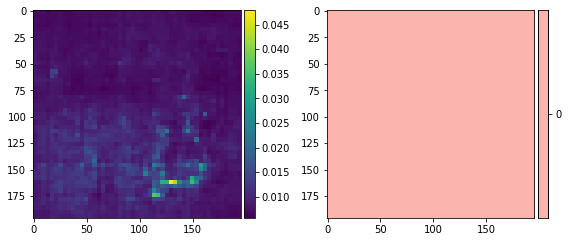

In [33]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm
from matplotlib.colorbar import ColorbarBase
from matplotlib import cm

fig = plt.figure(figsize=(8, 8))

ax1 = plt.subplot(1, 2, 1, aspect='equal')
hm = ax1.imshow(heatmap)

ax2 = plt.subplot(1, 2, 2, aspect='equal')


vals = np.unique(class_pixels).tolist()
bounds = vals + [vals[-1] + 1]  # add an extra item for cosmetic reasons

custom = cm.get_cmap('Pastel1', len(bounds)) # discrete colors


norm = BoundaryNorm(bounds, custom.N-1)

cp = ax2.imshow(class_pixels, norm=norm, cmap=custom)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(hm, cax=cax1)

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
cbar2 = ColorbarBase(cax2, cmap=custom, norm=norm,
                         # place the ticks at the average value between two entries
                         # e.g. [280, 300] -> 290
                         # so that they're centered on the colorbar
                         ticks=[(a + b) / 2.0 for a, b in zip(bounds[::], bounds[1::])],
                         boundaries=bounds, spacing='uniform', orientation='vertical')

cbar2.ax.set_yticklabels([n for n in np.unique(class_pixels)])

fig.tight_layout()

plt.show()


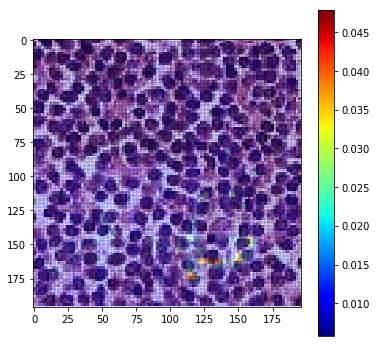

In [34]:
import cv2

plt.figure(figsize=(6, 6))

plt.imshow(img, cmap=cm.gray)

plt.pcolormesh(heatmap, cmap=plt.cm.jet, alpha=0.1)
plt.colorbar().solids.set(alpha=1)
plt.savefig("occlusion-%d-%f.png"%(i, pred))
plt.show()


In [35]:
heatmap.shape

(196, 196)

In [36]:
img.shape

(196, 196, 3)

new_img = np.multiply(img[0], heatmap)

np.multiply(img, heatmap)

new_img = np.rollaxis(np.multiply(np.rollaxis(img, 2, 0), heatmap),0,3)

plt.imshow(new_img)

max_val = np.max(heatmap)
min_val = np.min(heatmap)
threshold = np.percentile(heatmap, 25)
diff = max_val - min_val
scaler = (heatmap - min_val)/diff

new_img = np.rollaxis(np.multiply(np.rollaxis(img, 2, 0), scaler),0,3) + np.rollaxis(np.multiply(np.rollaxis(np.ones(img.shape), 2, 0), (1-scaler)),0,3)

np.max(scaler)

plt.imshow(new_img)

min_val

In [37]:
import scipy as sp
from scipy.misc import imread
from scipy.signal.signaltools import correlate2d as c2d
def convert_imd(data):
    data = sp.inner(data, [299, 587, 114]) /1000.0
    return (data - data.mean())/ data.std()



In [39]:
c2d(heatmap,heatmap)

array([[4.8405378e-05, 9.6810756e-05, 1.4521614e-04, ..., 1.7782829e-04,
        1.1855219e-04, 5.9276095e-05],
       [9.6810756e-05, 1.9362151e-04, 2.9043228e-04, ..., 3.5565658e-04,
        2.3710438e-04, 1.1855219e-04],
       [1.4521614e-04, 2.9043228e-04, 4.3564840e-04, ..., 5.3348485e-04,
        3.5565658e-04, 1.7782829e-04],
       ...,
       [1.7782829e-04, 3.5565658e-04, 5.3348485e-04, ..., 4.3564840e-04,
        2.9043228e-04, 1.4521614e-04],
       [1.1855219e-04, 2.3710438e-04, 3.5565658e-04, ..., 2.9043228e-04,
        1.9362151e-04, 9.6810756e-05],
       [5.9276095e-05, 1.1855219e-04, 1.7782829e-04, ..., 1.4521614e-04,
        9.6810756e-05, 4.8405378e-05]], dtype=float32)

In [40]:
def calc_heatmap(X_train, Y_train):
    result = pd.DataFrame(index=range(X_train.shape[0]),columns=["actual", "predicted", "mean", "max", "var"])
    result.loc[:,"actual"] = Y_train
    
    for i in range(X_train.shape[0]):
        # for example
        data = X_train[i]
        print(Y_train[i])
        correct_class = np.argmax(Y_train[i])
        print(correct_class)

        # input tensor for model.predict
        inp = data.reshape(1, IMG_SIZE, IMG_SIZE, 3)

        # image data for matplotlib's imshow
        img = data.reshape(IMG_SIZE, IMG_SIZE, 3)

        # occlusion
        img_size = img.shape[0]
        occlusion_size = 4

        # preview
        _ = plt.imshow(img)
        plt.savefig("preocclusion-%d-%d.png"%(i,Y_train[i]))


        heatmap = np.zeros((IMG_SIZE, IMG_SIZE), np.float32)
        class_pixels = np.zeros((IMG_SIZE, IMG_SIZE), np.int16)

        from collections import defaultdict
        counters = defaultdict(int)

        for n, (x, y, img_float) in enumerate(iter_occlusion(data, size=occlusion_size)):   

            X = img_float.reshape(1, IMG_SIZE, IMG_SIZE, 3)
            out = my_model.predict(X)
            heatmap[y:y + occlusion_size, x:x + occlusion_size] = out[0][correct_class]
            class_pixels[y:y + occlusion_size, x:x + occlusion_size] = np.argmax(out)
            counters[np.argmax(out)] += 1

        pred = my_model.predict(inp)



        
        val = c2d(heatmap, convert_imd(img))
        
        result.loc[i, "predicted"] = pred
        result.loc[i, "mean"] = val.mean()
        result.loc[i, "max"] = val.max()
        result.loc[i,"var"] = val.var()
    return result


In [ ]:
result = calc_heatmap(X_train, Y_train)

1.0
0
0.0
0
1.0
0
1.0
0
1.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
1.0
0


In [ ]:
result["predicted"] = result["predicted"].apply(lambda x:x[0])


In [54]:
result[result.predicted<0.5].mean()


actual       7.317073e-02
predicted    6.829977e-02
mean        -4.606461e-14
max          3.284548e+02
var          4.238895e+04
dtype: float64

In [55]:
result[result.predicted>0.5].mean()


actual       9.130435e-01
predicted    9.401116e-01
mean        -1.808269e-13
max          3.346496e+03
var          2.009766e+06
dtype: float64

In [56]:
result[result["actual"]==1].mean()

actual       1.000000e+00
predicted    8.607636e-01
mean         7.635322e-14
max          2.947161e+03
var          1.756236e+06
dtype: float64

In [57]:
result[result["actual"]==0].mean()

actual       0.000000e+00
predicted    9.411327e-02
mean        -1.970036e-13
max          4.926048e+02
var          1.453230e+05
dtype: float64

In [143]:
negative_vals.reshape(1,82).shape

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


(1, 82)

[    0.          1111.11111111  2222.22222222  3333.33333333
  4444.44444444  5555.55555556  6666.66666667  7777.77777778
  8888.88888889 10000.        ]


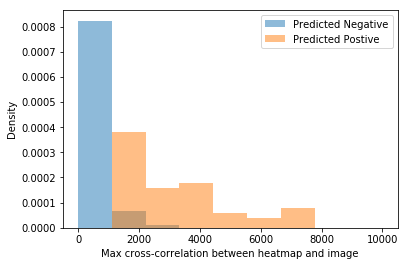

In [146]:
negative_vals = result[result.predicted < 0.5]["max"]
positive_vals = result[result.predicted > 0.5]["max"]
bins = np.linspace(0,10000, 10)
print(bins)
plt.hist(list(negative_vals), bins, alpha = 0.5, label="Predicted Negative",density=True)
plt.hist(list(positive_vals), bins, alpha=0.5, label="Predicted Postive",density=True)
plt.legend(loc="upper right")
plt.xlabel("Max cross-correlation between heatmap and image")
plt.ylabel("Density")
plt.savefig("cross-correlation.png")
plt.show()

In [131]:
len(negative_vals)

82

(array([4., 0., 0., 0., 1., 1., 0., 0., 1., 1.]),
 array([1.123414  , 1.53448491, 1.94555583, 2.35662674, 2.76769766,
        3.17876857, 3.58983948, 4.0009104 , 4.41198131, 4.82305223,
        5.23412314]),
 <a list of 10 Patch objects>)

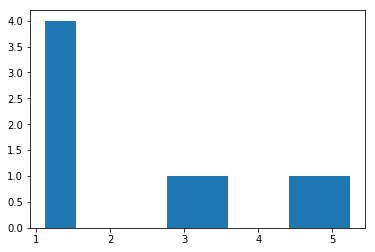

In [110]:
test = [1.2,1.23421,1.123414,1.27623,3.2134,3.1234,4.543,5.23412314]
plt.hist(test)

In [107]:
negative_vals[negative_vals < 100].shape[0]

28

In [90]:
counts = []
for i in range(int(result["max"].max()//100) ):
    counts.append(result[result["max"] < 100*i].shape[0])

In [94]:
for i in reversed(range(1,len(counts))):
    counts[i] = counts[i] - counts[i-1]

In [99]:
counts

[0,
 28,
 19,
 9,
 6,
 5,
 2,
 2,
 0,
 1,
 2,
 1,
 2,
 4,
 2,
 3,
 3,
 2,
 4,
 0,
 3,
 2,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 1,
 2,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

[148.54807410595666 13.799271597296526 3409.156413708336
 1224.5779582412436 1374.946991953664 149.6539554627472 41.45063937330378
 1200.8502685506799 169.69062034117994 312.58292199583667 846.428495162758
 15.198212456910166 194.60956857443003 1550.4449155231887
 1981.1025881460466 24.715321906286572 4590.005281780843 1598.201776415057
 127.58789085594385 57.15996093916452 1597.2067501461868
 345.59098993756953 5918.7535900749135 147.93360931939185
 1768.9730912011946 628.1515450711436 4149.00836184515 5954.608983380559
 1125.8100771854922 1976.0172617810094 363.103837446188 391.9913923373145
 315.7203836177393 3164.391801007554 409.47336601708355 20.929734276051438
 445.3685844274115 411.05982004054243 151.70053347092272 3652.247576754609
 61.489349499865234 114.73468083943382 287.227047546662 2005.4608548361607
 49.10258504301479 224.13796215772024 4626.874837162615 4321.500682183998
 48.49969656534699 39.70811557376319 75.92754836797639 496.42297066580716
 1685.6742141218394 2970.8

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


([array([0.00084944, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ]), array([0.00084944, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ]), array([0.        , 0.        , 0.00084944, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ]), array([0.        , 0.00084944, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ]), array([0.        , 0.00084944, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ]), array([0.00084944, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ]), array([0.00084944, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ]), array([0.        , 0.00084944, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ]), array(

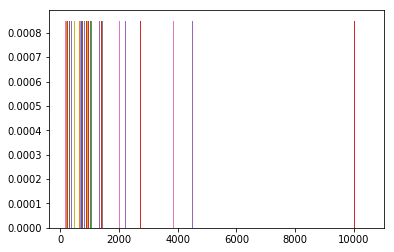

In [75]:
here = np.arrayresult["max"])
print(here)

bins = np.linspace(here.min(),here.max(), 10)
print(bins)

print(plt.hist(np.array(result["max"]), normed=True, bins=bins))
plt.show()

In [51]:
result

,actual,predicted,mean,max,var
0,1.0,0.018248,-6.37737e-14,148.548,2041.53
1,0.0,0.009637,2.35582e-14,13.7993,13.6455
2,1.0,0.874579,9.52607e-13,3409.16,1.54511e+06
3,1.0,1.000000,-3.9445e-12,1224.58,216784
4,1.0,0.943309,-4.66633e-12,1374.95,269877
5,0.0,0.020546,3.31242e-14,149.654,4043.65
6,0.0,0.010082,-1.66186e-14,41.4506,111.717
7,0.0,0.127233,-9.21387e-13,1200.85,299241
8,0.0,0.070628,1.57507e-13,169.691,2877.97
9,0.0,0.081839,8.05928e-13,312.583,8266.95


In [52]:
result.to_csv("occlusion_correlation_results.csv")